In [61]:
import pandas as pd
import numpy as np
import seaborn as sn
from numpy import array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import keras_nlp
import gc
import keras_tuner as kt
import json
from keras_tuner.engine.hyperparameters import HyperParameters

In [2]:
submission = False

attentioned_cnn_BiLSTM_training = False
tf_idf_classifier_training = False
final_model_training = False

attentioned_cnn_BiLSTM_hp_tuning = False
tf_idf_classifier_hp_tuning = False

# Data loading and understanding

In [3]:
df = pd.read_csv("/kaggle/input/daigt-v4-train-dataset/train_v4_drcat_01.csv", sep=',')

**Data understanding**

In [4]:
df.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


In [5]:
df.shape

(73573, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73573 entries, 0 to 73572
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           73573 non-null  object
 1   label          73573 non-null  int64 
 2   prompt_name    73573 non-null  object
 3   source         73573 non-null  object
 4   RDizzl3_seven  73573 non-null  bool  
 5   model          73573 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 2.9+ MB


In [7]:
df.describe()

,label
count,73573.000000
mean,0.627989
std,0.483345
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
class_counts = df['label'].value_counts()
print(class_counts)

label
1    46203
0    27370
Name: count, dtype: int64


**Class label distibution**

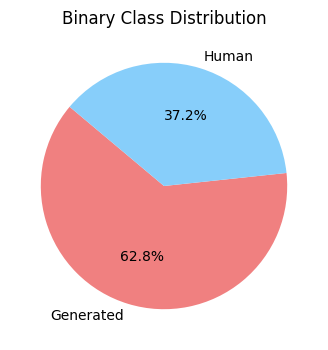

In [9]:
class_labels_for_plot = class_counts.index.map({0: 'Human', 1: 'Generated'})

plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_labels_for_plot, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue'])

plt.title('Binary Class Distribution')
plt.show()

**Word count statistics**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


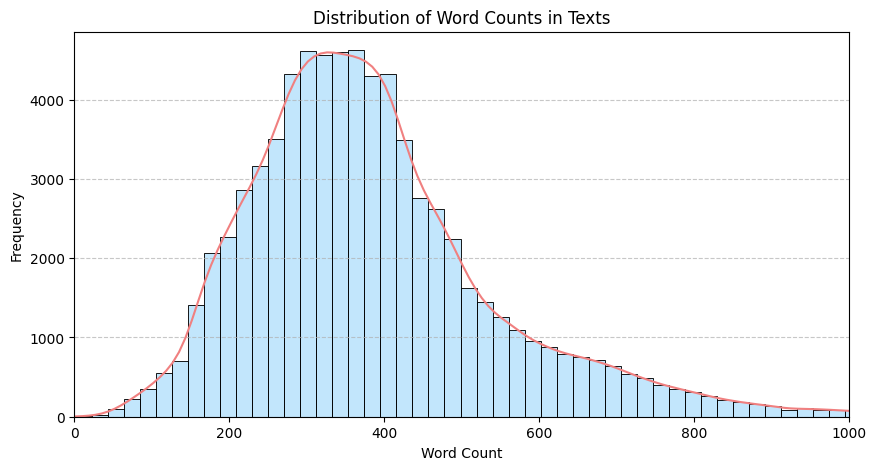

In [10]:
plt.figure(figsize=(10, 5))
word_count = np.array([len(text.split()) for text in df['text']])
ax = sn.histplot(word_count, bins=80, kde=True, color='lightskyblue', edgecolor='black')
ax.lines[0].set_color('lightcoral')
plt.title('Distribution of Word Counts in Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 1000)
plt.show()

**Training and test set creation**

In [11]:
docs = df['text']
labels = array(df['label'])

training_data, test_data, train_label, test_label = train_test_split(docs, labels, test_size = 0.2, random_state=0)
print(training_data.shape, test_data.shape, train_label.shape, test_label.shape)

(58858,) (14715,) (58858,) (14715,)


In [12]:
del df
del docs
del labels
gc.collect()

145

# Words tokenization

**Integer text tokenization**

In [13]:
max_tokens = 20000  # Maximum vocab size.
max_len = 350 # Sequence length to pad the outputs to.
    
text_vectorization = tf.keras.layers.TextVectorization(standardize='lower_and_strip_punctuation',
                                                       max_tokens=max_tokens,
                                                       output_mode='int',
                                                       output_sequence_length=max_len)

text_vectorization.adapt(training_data, batch_size=None)
vocab_size = text_vectorization.vocabulary_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 20000


**TF-IDF text tokenization**

In [14]:
tf_idf_text_vectorization = tf.keras.layers.TextVectorization(standardize='lower_and_strip_punctuation',
                                                              max_tokens=max_tokens,
                                                              output_mode='tf_idf',
                                                              ngrams=2)

tf_idf_text_vectorization.adapt(training_data, batch_size=None)
tf_idf_vocab_size = tf_idf_text_vectorization.vocabulary_size()
print(f"Vocabulary size: {tf_idf_vocab_size}")

Vocabulary size: 20000


# Embedding matrix

In [15]:
embedding_dim = 200

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Load GloVe embeddings into a matrix
def load_embeddings(file_path):
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            index = word_index.get(word, None)
            if index is not None:
                embedding_matrix[index] = coefs
    return embedding_matrix

glove_embeddings_path = '/kaggle/input/glove-embeddings/glove.6B.200d.txt'
embedding_matrix = load_embeddings(glove_embeddings_path)
print(f"Created an embedding matrix of shape {embedding_matrix.shape}")

Created an embedding matrix of shape (20000, 200)


# Positional Embedding matrix

In [16]:
def positional_encoding_matrix(sequence_length, embedding_dim, n=10000):
    positional_encoding_matrix = np.zeros((sequence_length, embedding_dim))
    for k in range(sequence_length):
        for i in np.arange(int(embedding_dim/2)):
            denominator = np.power(n, 2*i/embedding_dim)
            positional_encoding_matrix[k, 2*i] = np.sin(k/denominator)
            positional_encoding_matrix[k, 2*i+1] = np.cos(k/denominator)
    return positional_encoding_matrix
 
positional_encoding_matrix = positional_encoding_matrix(sequence_length=max_len, 
                                                        embedding_dim=embedding_dim, 
                                                        n=100)

print(f"Created a positional embedding matrix of shape {positional_encoding_matrix.shape}")

Created a positional embedding matrix of shape (350, 200)


# Positional Embedding layer

In [17]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, voc_size, embedding_dim, embedding_matrix, positional_encoding_matrix, **kwargs):
        super().__init__(**kwargs)
        self.sequence_embeddings_layer = layers.Embedding(voc_size,
                                                          embedding_dim,
                                                          embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                                          trainable=False,
                                                          mask_zero=True)
        self.position_embedding_layer = layers.Embedding(sequence_length,
                                                         embedding_dim,
                                                         embeddings_initializer=keras.initializers.Constant(positional_encoding_matrix),
                                                         trainable=False)
    
    def call(self, inputs):        
        position_indices = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        embedded_sentence = self.sequence_embeddings_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_sentence + embedded_indices

# Attentioned CNN-BiLSTM classifier model

In [18]:
batch_size = 32

In [19]:
def build_CNN_BiLSTM_model(hp):
    intermediate_dim = 448
    num_heads = 3
    cnn_filters = hp.Int(name='filters', min_value=64, max_value=128, step=32)
    lstm_units = hp.Int(name='lstm_units', min_value=128, max_value=512, step=128)
    dense_units = hp.Int(name='dense_units', min_value=128, max_value=256, step=128)
    
    pooling_dim_reduction= 4
    
    #POSITIONAL ENCODINGS AND SELF-ATTENTION
    inputs = keras.Input(shape=(max_len,), batch_size=batch_size)
    x = PositionalEmbedding(max_len, max_tokens, embedding_dim, embedding_matrix, positional_encoding_matrix)(inputs)
    transformer_outputs = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads)(x)

    #CONVOLUTIONAL LAYERS
    cnns_inputs = layers.Reshape(target_shape=(max_len, embedding_dim, 1))(transformer_outputs)

    conv_1 = layers.Conv2D(filters=cnn_filters, kernel_size=2, activation='relu', padding='same')(cnns_inputs)
    conv_1 = layers.MaxPooling2D(pool_size=2)(conv_1)
    conv_1 = layers.Conv2D(filters=1, kernel_size=2, activation='relu', padding='same')(conv_1)
    conv_1 = layers.MaxPooling2D(pool_size=2)(conv_1)
    conv_1 = layers.Reshape((int(max_len/pooling_dim_reduction), int(embedding_dim/pooling_dim_reduction)))(conv_1)

    conv_2 = layers.Conv2D(filters=cnn_filters, kernel_size=3, activation='relu', padding='same')(cnns_inputs)
    conv_2 = layers.MaxPooling2D(pool_size=2)(conv_2)
    conv_2 = layers.Conv2D(filters=1, kernel_size=3, activation='relu', padding='same')(conv_2)
    conv_2 = layers.MaxPooling2D(pool_size=2)(conv_2)
    conv_2 = layers.Reshape((int(max_len/pooling_dim_reduction), int(embedding_dim/pooling_dim_reduction)))(conv_2)

    conv_3 = layers.Conv2D(filters=cnn_filters, kernel_size=4, activation='relu', padding='same')(cnns_inputs)
    conv_3 = layers.MaxPooling2D(pool_size=2)(conv_3)
    conv_3 = layers.Conv2D(filters=1, kernel_size=4, activation='relu', padding='same')(conv_3)
    conv_3 = layers.MaxPooling2D(pool_size=2)(conv_3)
    conv_3 = layers.Reshape((int(max_len/pooling_dim_reduction), int(embedding_dim/pooling_dim_reduction)))(conv_3)

    conv_4 = layers.Conv2D(filters=cnn_filters, kernel_size=5, activation='relu', padding='same')(cnns_inputs)
    conv_4 = layers.MaxPooling2D(pool_size=2)(conv_4)
    conv_4 = layers.Conv2D(filters=1, kernel_size=5, activation='relu', padding='same')(conv_4)
    conv_4 = layers.MaxPooling2D(pool_size=2)(conv_4)
    conv_4 = layers.Reshape((int(max_len/pooling_dim_reduction), int(embedding_dim/pooling_dim_reduction)))(conv_4)

    #LSTM LAYER
    x = layers.Concatenate()([conv_1, conv_2, conv_3, conv_4])
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs= layers.Dense(1, activation='sigmoid')(x)
    
    attentioned_cnn_BiLSTM = keras.Model(inputs, outputs, name='attentioned_cnn_BiLSTM')
    attentioned_cnn_BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return attentioned_cnn_BiLSTM

# TF-IDF Classification Model

In [20]:
def build_tf_idf_model(hp):
    first_dense_layer_units = hp.Int(name='first_dense_layer_units', min_value=128, max_value=512, step=128)
    second_dense_layer_units = hp.Int(name='second_dense_layer_units', min_value=64, max_value=128, step=64)
    third_dense_layer_units = hp.Int(name='third_dense_layer_units', min_value=32, max_value=64, step=32)
    
    optimizer = hp.Choice(name='optimizer', values=['rmsprop', 'adam'])
    
    inputs = keras.Input(shape=(max_tokens,), batch_size=batch_size)
    x = layers.Dense(first_dense_layer_units, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(second_dense_layer_units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(third_dense_layer_units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    tf_idf_classifier = keras.Model(inputs, outputs, name='tf_idf_classifier')
    tf_idf_classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return tf_idf_classifier

# Data preparation for hyperparameter tuning and model training

**CNN-BiLSTM and TF-IDF data generator**

In [21]:
from keras.utils import Sequence

class TrainingDataGenerator(Sequence):
    def __init__(self, data, labels, batch_size, text_vectorization, is_training):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))
        self.text_vectorization = text_vectorization
        self.is_training = is_training

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_data = tf.gather(self.data, batch_indexes)
        tokenized_batch =  self.text_vectorization(batch_data)
        batch_labels = self.labels[batch_indexes]
        return (tokenized_batch, batch_labels)
    
    def on_epoch_end(self):
        gc.collect()
        if self.is_training:
            np.random.shuffle(self.indexes)

**Final Model data generator**

In [22]:
class Final_Model_DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size, text_vectorization, tf_idf_text_vectorization, is_training):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))
        self.text_vectorization = text_vectorization
        self.tf_idf_text_vectorization = tf_idf_text_vectorization
        self.is_training = is_training

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_data = tf.gather(self.data, batch_indexes)
        tokenized_batch =  self.text_vectorization(batch_data)
        tf_idf_tokenized_batch =  self.tf_idf_text_vectorization(batch_data)
        batch_labels = self.labels[batch_indexes]
        return ({'attentioned_cnn_BiLSTM_inputs': tokenized_batch,
                 'tf_idf_classifier_inputs': tf_idf_tokenized_batch},
                batch_labels)
    
    def on_epoch_end(self):
        gc.collect()
        if self.is_training:
            np.random.shuffle(self.indexes)

# Hyperparameter tuning

In [23]:
hp_training_data, hp_val_data, hp_train_label, hp_val_label = train_test_split(training_data, train_label, test_size = 0.2, random_state=0)
print(hp_training_data.shape, hp_val_data.shape, hp_train_label.shape, hp_val_label.shape)

(47086,) (11772,) (47086,) (11772,)


**Attentioned CNN-BiLSTM hyperparameter tuning**

In [24]:
cnn_BiLSTM_hp_training_data_generator = TrainingDataGenerator(hp_training_data, hp_train_label, batch_size, text_vectorization, True)
cnn_BiLSTM_hp_val_data_generator = TrainingDataGenerator(hp_val_data, hp_val_label, batch_size, text_vectorization, False)

In [25]:
cnn_BiLSTM_tuner = kt.Hyperband(build_CNN_BiLSTM_model, objective = 'val_accuracy', 
                                max_epochs = 10, directory='cnn_BiLSTM_hp_tuning', 
                                project_name='cnn_BiLSTM_hp_tuning')
cnn_BiLSTM_tuner.search_space_summary()

if attentioned_cnn_BiLSTM_hp_tuning:
    hp_early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    cnn_BiLSTM_tuner.search(cnn_BiLSTM_hp_training_data_generator, validation_data=cnn_BiLSTM_hp_val_data_generator,
                            epochs=50, verbose=2, callbacks=[hp_early_stopping_callback])

Reloading Tuner from cnn_BiLSTM_hp_tuning/cnn_BiLSTM_hp_tuning/tuner0.json
Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': 'linear'}


**TF-IDF hyperparameter tuning**

In [26]:
tf_idf_hp_training_data_generator = TrainingDataGenerator(hp_training_data, hp_train_label, batch_size, tf_idf_text_vectorization, True)
tf_idf_hp_val_data_generator = TrainingDataGenerator(hp_val_data, hp_val_label, batch_size, tf_idf_text_vectorization, False)

In [27]:
tf_idf_tuner = kt.Hyperband(build_tf_idf_model, objective = 'val_accuracy', max_epochs = 10,
                            directory='tf_idf_hp_tuning', project_name='tf_idf_hp_tuning')
tf_idf_tuner.search_space_summary()

if tf_idf_classifier_hp_tuning:
    hp_early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    tf_idf_tuner.search(tf_idf_hp_training_data_generator, validation_data=tf_idf_hp_val_data_generator,
                            epochs=50, verbose=2, callbacks=[hp_early_stopping_callback])

Reloading Tuner from tf_idf_hp_tuning/tf_idf_hp_tuning/tuner0.json
Search space summary
Default search space size: 4
first_dense_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
second_dense_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
third_dense_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


# Best Model Training

**Attentioned CNN-BiLSTM classifier training**

Model: "attentioned_cnn_BiLSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(32, 350)]                  0         []                            
                                                                                                  
 positional_embedding (Posi  (32, 350, 200)               4070000   ['input_1[0][0]']             
 tionalEmbedding)                                                                                 
                                                                                                  
 transformer_encoder (Trans  (32, 350, 200)               339842    ['positional_embedding[0][0]']
 formerEncoder)                                                                                   
                                                                             

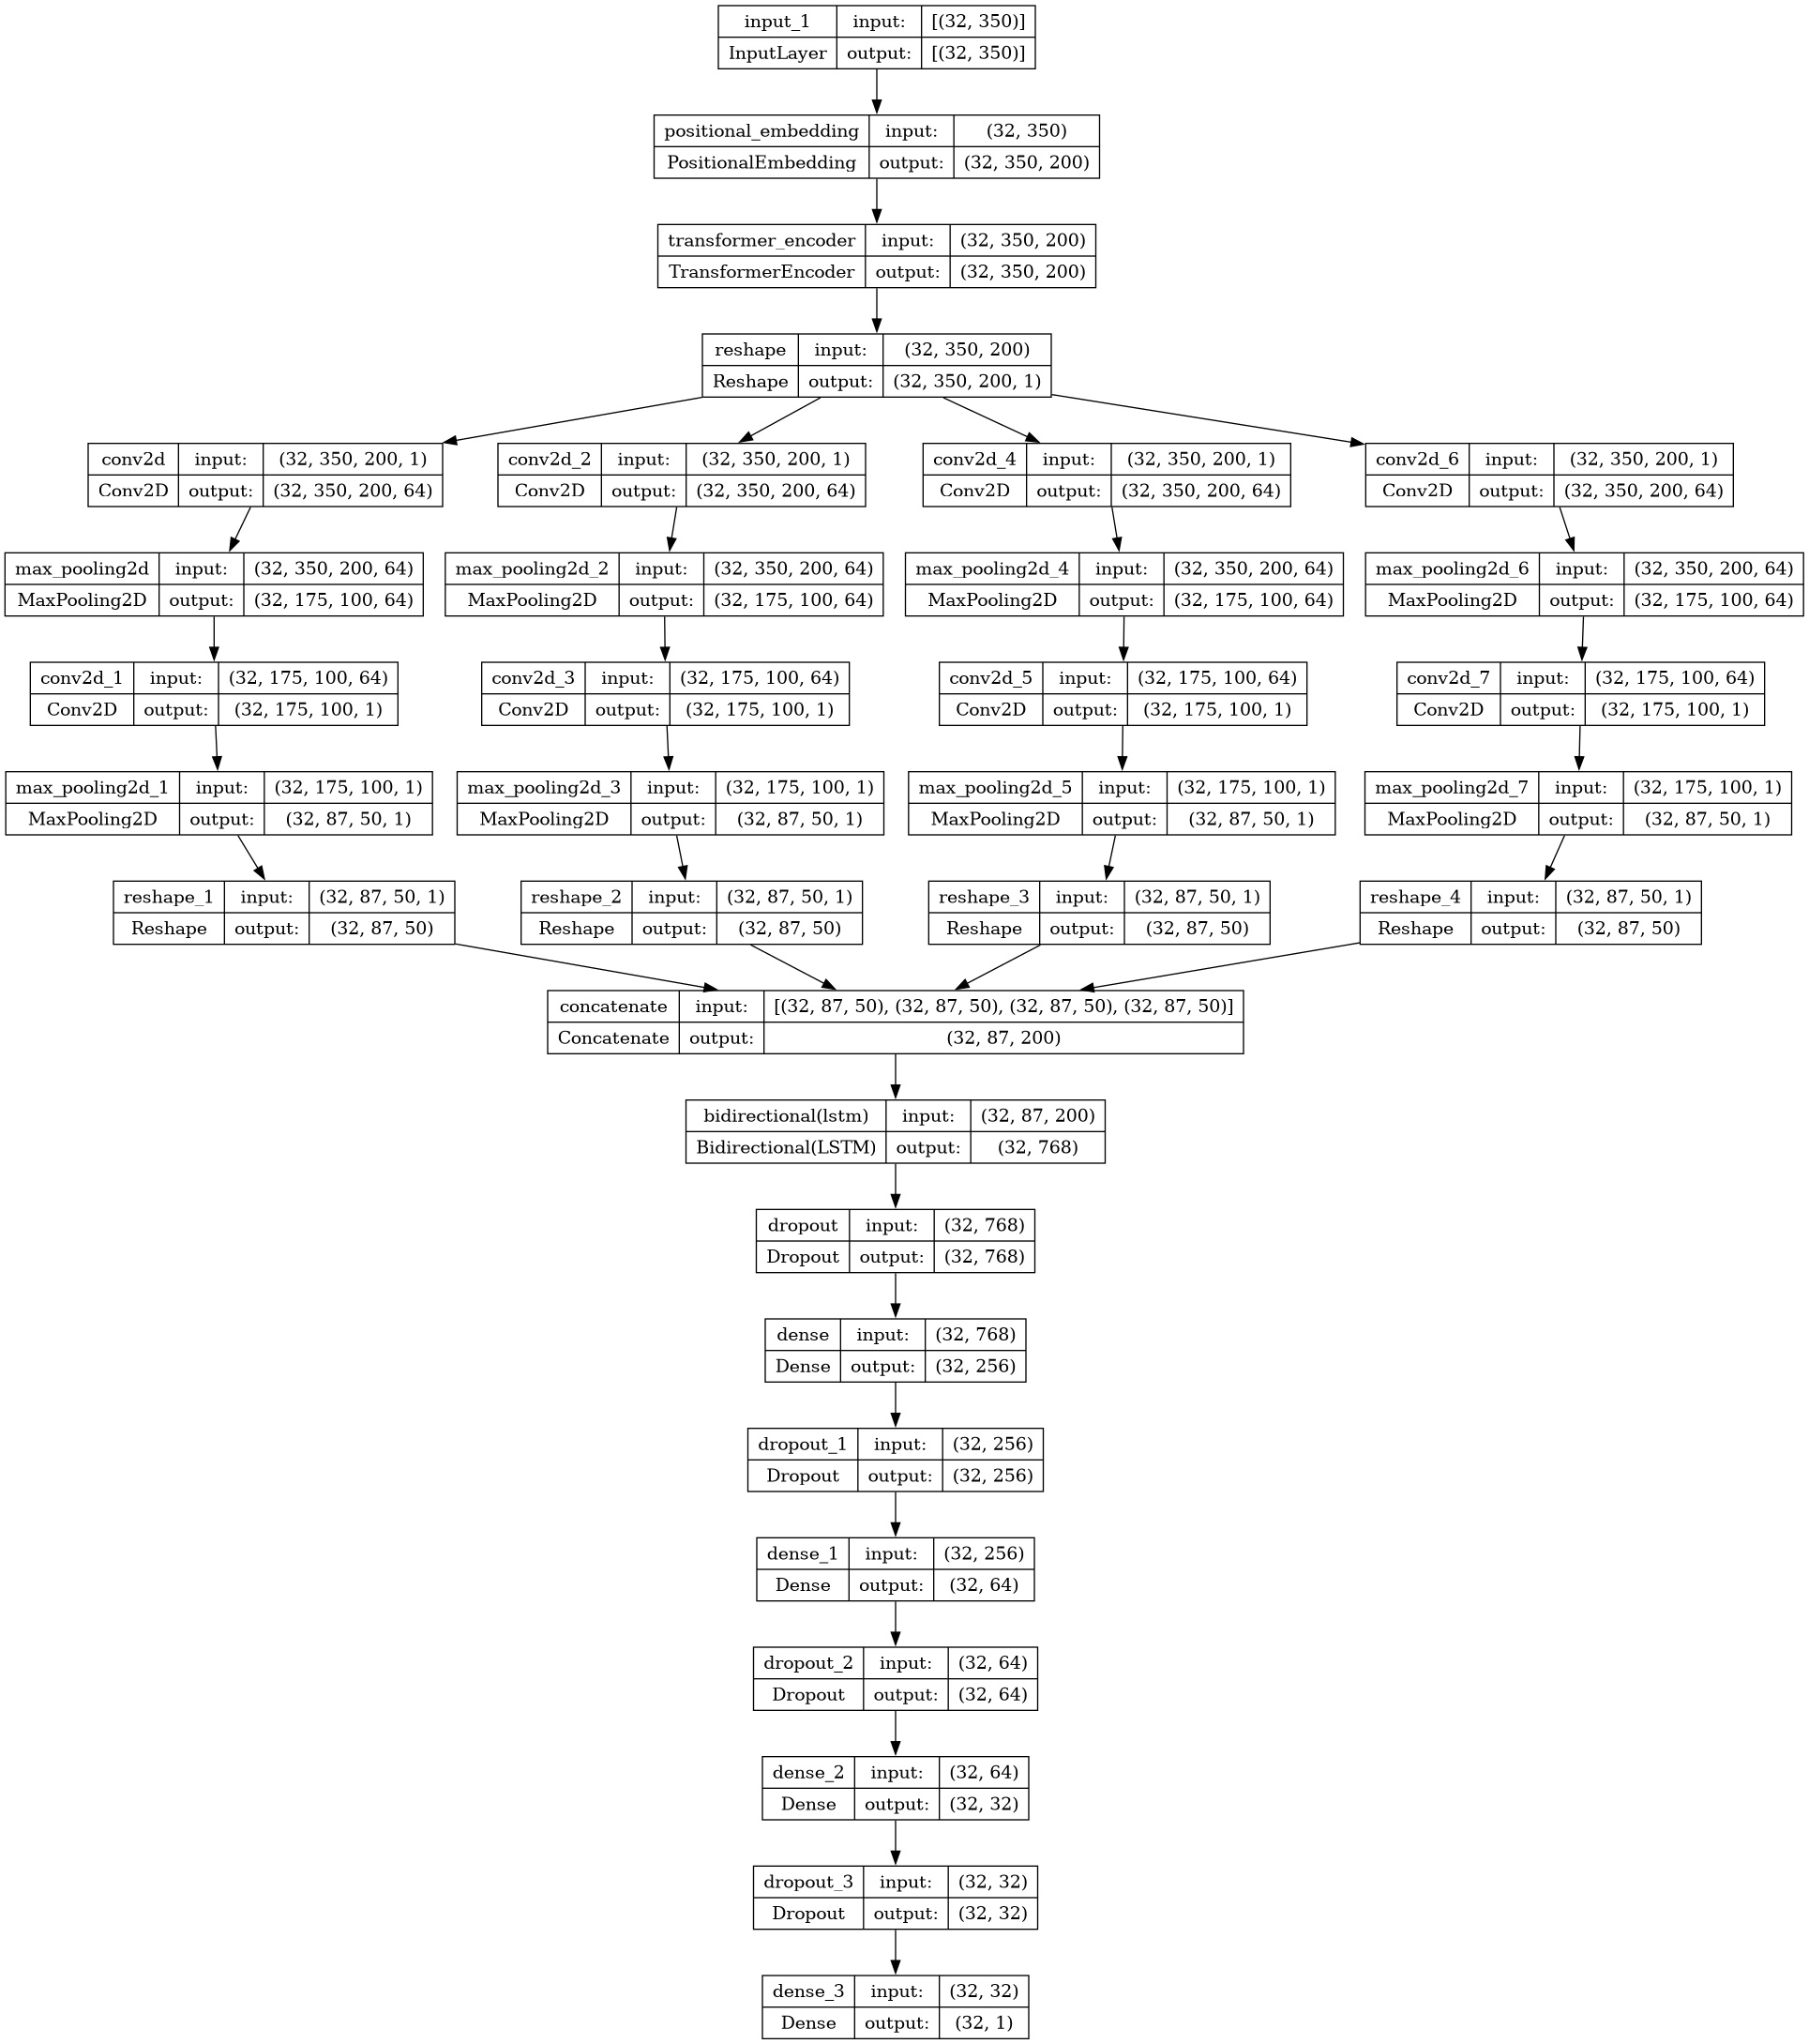

In [28]:
if submission:
    with open('/kaggle/input/final-model-weights/cnn_BiLSTM_hps.json', 'r') as f:
        best_cnn_BiLSTM_hps_config = json.load(f)
    best_cnn_BiLSTM_hps = HyperParameters.from_config(best_cnn_BiLSTM_hps_config)
else:
    best_cnn_BiLSTM_hps = cnn_BiLSTM_tuner.get_best_hyperparameters(num_trials=1)[0]
    with open('cnn_BiLSTM_hps.json', 'w') as f:
        json.dump(best_cnn_BiLSTM_hps.get_config(), f)

attentioned_cnn_BiLSTM = cnn_BiLSTM_tuner.hypermodel.build(best_cnn_BiLSTM_hps)
attentioned_cnn_BiLSTM.summary()
keras.utils.plot_model(attentioned_cnn_BiLSTM, show_shapes=True, to_file='attentioned_cnn_BiLSTM.png')

In [29]:
cnn_BiLSTM_training_data_generator = TrainingDataGenerator(training_data, train_label, batch_size, text_vectorization, True)
cnn_BiLSTM_val_data_generator = TrainingDataGenerator(test_data, test_label, batch_size, text_vectorization, False)

In [30]:
attentioned_cnn_BiLSTM_early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
attentioned_cnn_BiLSTM_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='attentioned_cnn_BiLSTM.weights.h5', 
                                                                             monitor='val_loss', save_best_only=True,
                                                                             save_weights_only=True)
attentioned_cnn_BiLSTM_logger_callback = keras.callbacks.CSVLogger(filename='attentioned_cnn_BiLSTM_logs.csv', separator=",", append=True)

if not submission:
    attentioned_cnn_BiLSTM_weights_path = '/kaggle/working/attentioned_cnn_BiLSTM.weights.h5'
    
    if os.path.exists(attentioned_cnn_BiLSTM_weights_path):
        print("Loading CNN-BiLSTM existing weights...")
        attentioned_cnn_BiLSTM.load_weights(attentioned_cnn_BiLSTM_weights_path)
    
if attentioned_cnn_BiLSTM_training:
    attentioned_cnn_BiLSTM_hystory = attentioned_cnn_BiLSTM.fit(cnn_BiLSTM_training_data_generator, validation_data = cnn_BiLSTM_val_data_generator, epochs = 20, 
                                                                callbacks=[attentioned_cnn_BiLSTM_early_stopping_callback,
                                                                           attentioned_cnn_BiLSTM_checkpoint_callback,
                                                                           attentioned_cnn_BiLSTM_logger_callback])

Loading CNN-BiLSTM existing weights...


**TF-IDF classifier training**

Model: "tf_idf_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 20000)]             0         
                                                                 
 dense_4 (Dense)             (32, 512)                 10240512  
                                                                 
 dropout_4 (Dropout)         (32, 512)                 0         
                                                                 
 dense_5 (Dense)             (32, 128)                 65664     
                                                                 
 dropout_5 (Dropout)         (32, 128)                 0         
                                                                 
 dense_6 (Dense)             (32, 64)                  8256      
                                                                 
 dropout_6 (Dropout)         (32, 64)            

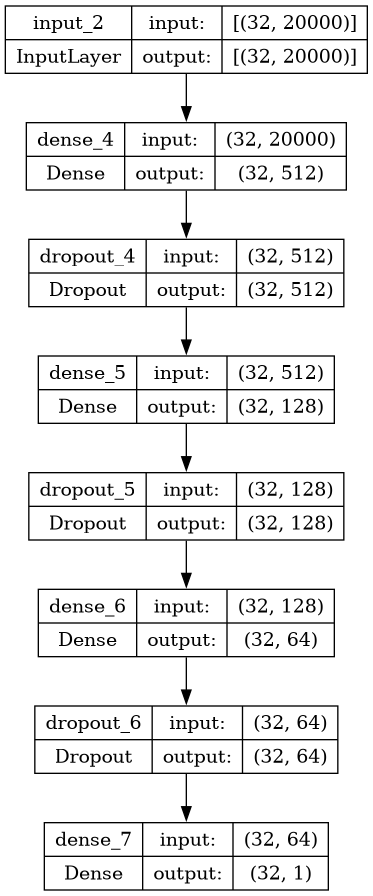

In [31]:
if submission:
    with open('/kaggle/input/final-model-weights/tf_idf_hps.json', 'r') as f:
        best_tf_idf_hps_config = json.load(f)
    best_tf_idf_hps = HyperParameters.from_config(best_tf_idf_hps_config)
else:
    best_tf_idf_hps = tf_idf_tuner.get_best_hyperparameters(num_trials=1)[0]
    with open('tf_idf_hps.json', 'w') as f:
        json.dump(best_tf_idf_hps.get_config(), f)

tf_idf_classifier = tf_idf_tuner.hypermodel.build(best_tf_idf_hps)
tf_idf_classifier.summary()
keras.utils.plot_model(tf_idf_classifier, show_shapes=True, to_file='tf_idf_classifier.png')

In [32]:
tf_idf_training_data_generator = TrainingDataGenerator(training_data, train_label, batch_size, tf_idf_text_vectorization, True)
tf_idf_val_data_generator = TrainingDataGenerator(test_data, test_label, batch_size, tf_idf_text_vectorization, False)

In [33]:
tf_idf_classifier_early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tf_idf_classifier_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='tf_idf_classifier.weights.h5', 
                                                                             monitor='val_loss', save_best_only=True,
                                                                             save_weights_only=True)
tf_idf_classifier_logger_callback = keras.callbacks.CSVLogger(filename='tf_idf_classifier_logs.csv', separator=",", append=True)

if not submission:
    tf_idf_classifier_weights_path = '/kaggle/working/tf_idf_classifier.weights.h5'
    
    if os.path.exists(tf_idf_classifier_weights_path):
        print("Loading TD-IDF Classifier existing weights...")
        tf_idf_classifier.load_weights(tf_idf_classifier_weights_path)
    
if tf_idf_classifier_training:
    tf_idf_classifier_hystory = tf_idf_classifier.fit(tf_idf_training_data_generator, validation_data = tf_idf_val_data_generator, epochs = 20, 
                                                                callbacks=[tf_idf_classifier_early_stopping_callback,
                                                                           tf_idf_classifier_checkpoint_callback,
                                                                           tf_idf_classifier_logger_callback])

Loading TD-IDF Classifier existing weights...


# Final Average Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attentioned_cnn_BiLSTM_inp  [(32, 350)]                  0         []                            
 uts (InputLayer)                                                                                 
                                                                                                  
 tf_idf_classifier_inputs (  [(32, 20000)]                0         []                            
 InputLayer)                                                                                      
                                                                                                  
 attentioned_cnn_BiLSTM (Fu  (32, 1)                      6429559   ['attentioned_cnn_BiLSTM_input
 nctional)                                                          s[0][0]']                 

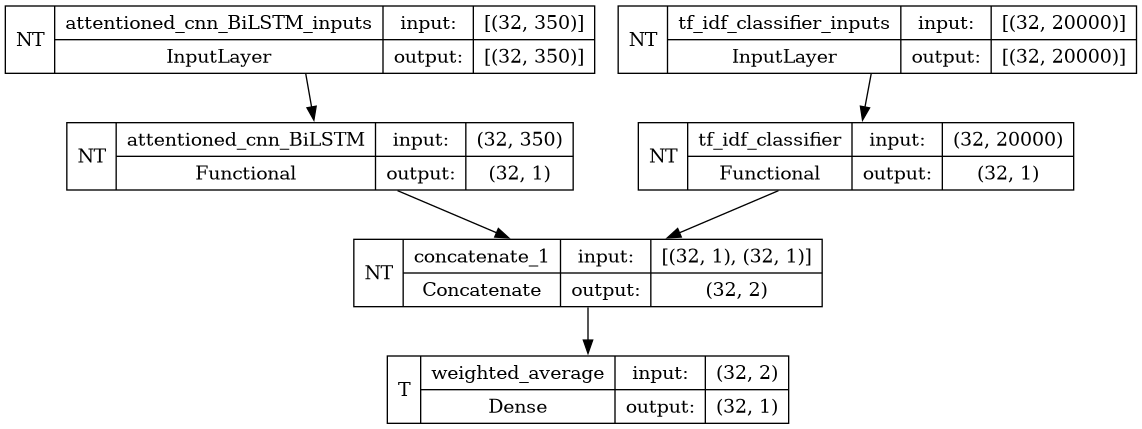

In [34]:
attentioned_cnn_BiLSTM_inputs = keras.Input(shape=(max_len,), batch_size=batch_size, name='attentioned_cnn_BiLSTM_inputs')
tf_idf_classifier_inputs = keras.Input(shape=(max_tokens,), batch_size=batch_size, name='tf_idf_classifier_inputs')

attentioned_cnn_BiLSTM_outputs = attentioned_cnn_BiLSTM(attentioned_cnn_BiLSTM_inputs)
tf_idf_classifier_outputs = tf_idf_classifier(tf_idf_classifier_inputs)

#FINAL MODEL
concatenated_outputs = layers.Concatenate()([attentioned_cnn_BiLSTM_outputs, tf_idf_classifier_outputs])
weighted_average = layers.Dense(1, activation='sigmoid', name='weighted_average')(concatenated_outputs)

final_model = keras.Model([attentioned_cnn_BiLSTM_inputs, tf_idf_classifier_inputs], weighted_average)

for layer in final_model.layers:
    if layer.name != 'weighted_average':
        layer.trainable = False

final_model.summary()
keras.utils.plot_model(final_model, show_trainable=True, show_shapes=True, to_file='final_model.png')

**Final Model training**

In [35]:
final_model_training_data_generator = Final_Model_DataGenerator(training_data, train_label, batch_size, text_vectorization, tf_idf_text_vectorization, True)
final_model_val_data_generator = Final_Model_DataGenerator(test_data, test_label, batch_size, text_vectorization, tf_idf_text_vectorization, False)

In [36]:
final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

final_model_early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
final_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='final_model.weights.h5', 
                                                                             monitor='val_loss', save_best_only=True,
                                                                             save_weights_only=True)
final_model_logger_callback = keras.callbacks.CSVLogger(filename='final_model_logs.csv', separator=",", append=True)

if submission:
    final_model_weights_path = '/kaggle/input/final-model-weights/final_model.weights.h5'
else:
    final_model_weights_path = '/kaggle/working/final_model.weights.h5'
    
if os.path.exists(final_model_weights_path):
    print("Loading Final Model existing weights...")
    final_model.load_weights(final_model_weights_path)
    
if final_model_training:
    final_model_hystory = final_model.fit(final_model_training_data_generator, validation_data = final_model_val_data_generator, epochs = 10, 
                                                                callbacks=[final_model_early_stopping_callback,
                                                                           final_model_checkpoint_callback,
                                                                           final_model_logger_callback])

Loading Final Model existing weights...


# Training metrics plot

In [37]:
def training_metrics_plot(train_logs_path):
    if submission:
        train_logs_path = os.path.join('/kaggle/input/final-model-weights/', train_logs_path)
    else:
        train_logs_path = os.path.join('/kaggle/working/', train_logs_path)
    
    train_logs = pd.read_csv(train_logs_path)
    
    #LOSS PLOT
    plt.plot(train_logs['loss'])
    plt.plot(train_logs['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

    #ACCURACY PLOT
    plt.plot(train_logs['accuracy'])
    plt.plot(train_logs['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

**CNN-BiLSTM training metrics plots**

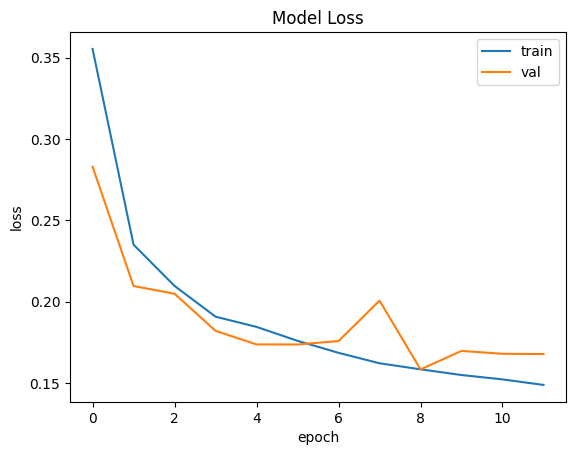

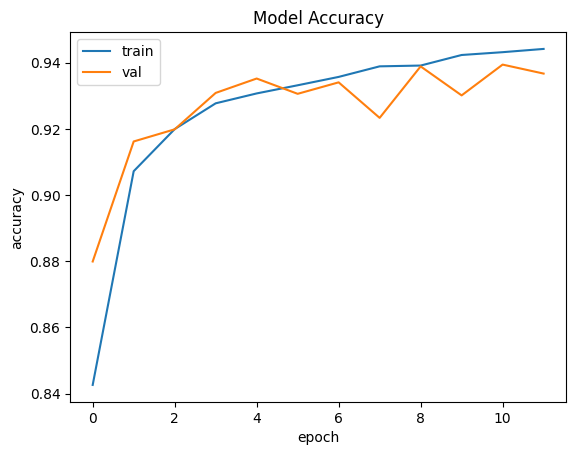

In [38]:
if submission:
    training_metrics_plot('/kaggle/input/final-model-weights/attentioned_cnn_BiLSTM_logs.csv')
else:
    training_metrics_plot('attentioned_cnn_BiLSTM_logs.csv')

**TF-IDF training metrics plots**

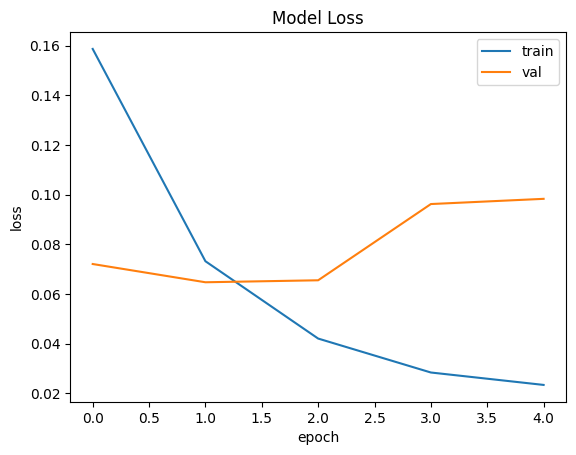

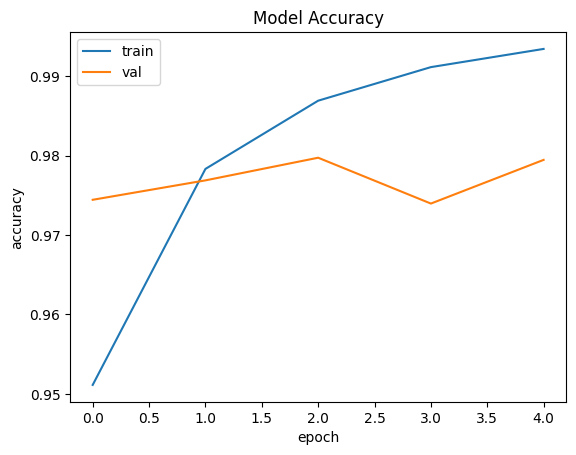

In [39]:
if submission:
    training_metrics_plot('/kaggle/input/final-model-weights/tf_idf_classifier_logs.csv')
else:
    training_metrics_plot('tf_idf_classifier_logs.csv')

**Final Model training metrics plots**

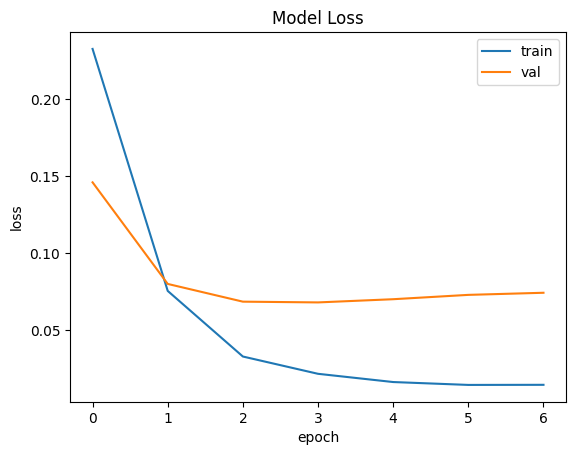

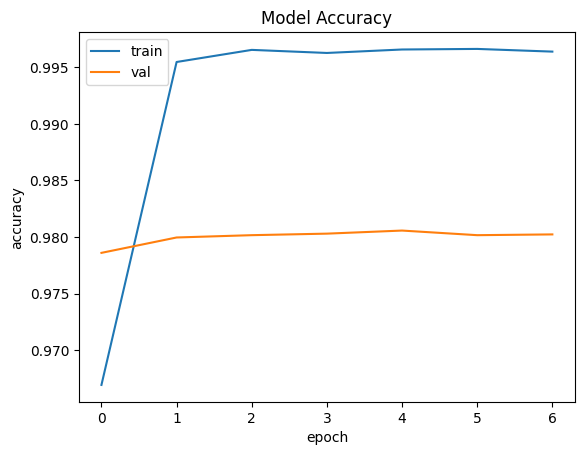

In [40]:
if submission:
    training_metrics_plot('/kaggle/input/final-model-weights/final_model_logs.csv')
else:
    training_metrics_plot('final_model_logs.csv')

# Model Evaluation

**CNN-BiLSTM and TF-IDF classifier test data batches generator**

In [41]:
from keras.utils import Sequence

class TestDataGenerator(Sequence):
    def __init__(self, data, batch_size, text_vectorization):
        self.data = data
        self.batch_size = batch_size
        self.text_vectorization = text_vectorization

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]
        tokenized_batch =  self.text_vectorization(batch_data)
        return tokenized_batch


In [42]:
cnn_BiLSTM_test_data_generator = TestDataGenerator(test_data, batch_size, text_vectorization)

In [43]:
tf_idf_test_data_generator = TestDataGenerator(test_data, batch_size, tf_idf_text_vectorization)

**Final Model test data batches generator**

In [44]:
class Final_Model_TestDataGenerator(Sequence):
    def __init__(self, data, batch_size, text_vectorization, tf_idf_text_vectorization):
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))
        self.text_vectorization = text_vectorization
        self.tf_idf_text_vectorization = tf_idf_text_vectorization

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_data = tf.gather(self.data, batch_indexes)
        tokenized_batch =  self.text_vectorization(batch_data)
        tf_idf_tokenized_batch =  self.tf_idf_text_vectorization(batch_data)
        return {'attentioned_cnn_BiLSTM_inputs': tokenized_batch, 'tf_idf_classifier_inputs': tf_idf_tokenized_batch}

In [45]:
final_model_test_data_generator = Final_Model_TestDataGenerator(test_data, batch_size, text_vectorization, tf_idf_text_vectorization)

**Prediction**

In [46]:
def model_prediction(model, test_data_generator):
    predictions = model.predict(test_data_generator)
    return np.round(predictions)

In [47]:
if not submission:
    cnn_BiLSTM_predictions = model_prediction(attentioned_cnn_BiLSTM, cnn_BiLSTM_test_data_generator)
    tf_idf_predictions = model_prediction(tf_idf_classifier, tf_idf_test_data_generator)
    final_model_predictions = model_prediction(final_model, final_model_test_data_generator)

460/460 [==============================] - 31s 65ms/step


**Confusion Matrix**

In [48]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(predictions):
    confusion_matrix_plot = confusion_matrix(test_label, predictions)
    sn.heatmap(confusion_matrix_plot, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

**CNN-BiLSTM confusion matrix**

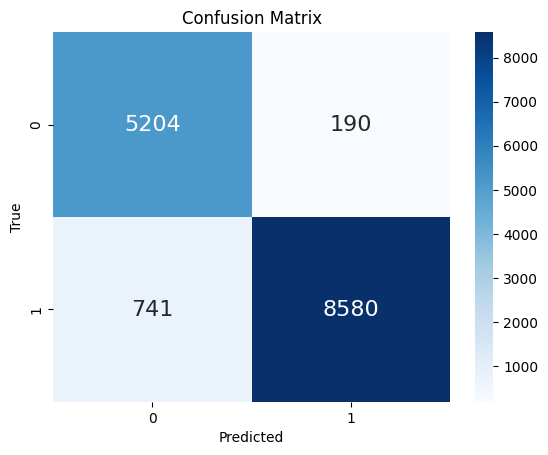

In [49]:
if not submission:
    confusion_matrix_plot(cnn_BiLSTM_predictions)

**TF-IDF confusion matrix**

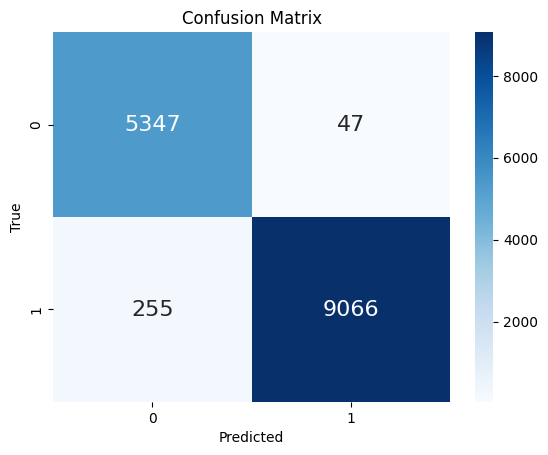

In [50]:
if not submission:
    confusion_matrix_plot(tf_idf_predictions)

**Final model confusion matrix**

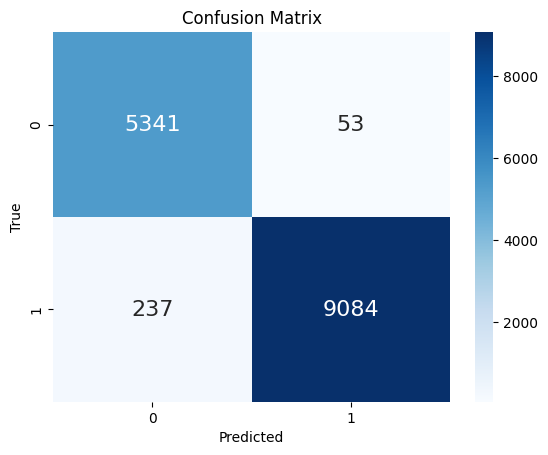

In [51]:
if not submission:
    confusion_matrix_plot(final_model_predictions)

**ROC Curve**

In [52]:
from sklearn.metrics import roc_curve, auc

def roc_curve_plot(predictions):
    fpr, tpr, thresholds = roc_curve(test_label, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

**CNN-BiLSTM ROC curve**

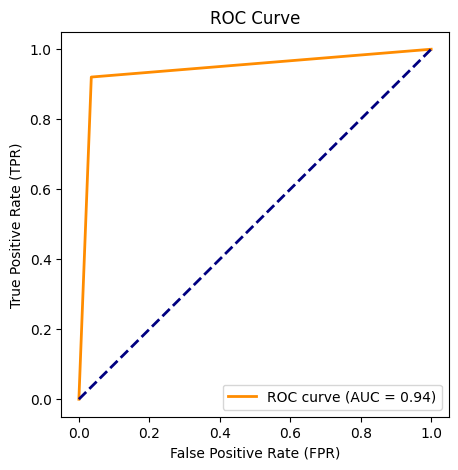

In [53]:
if not submission:
    roc_curve_plot(cnn_BiLSTM_predictions)

**TF-IDF ROC curve**

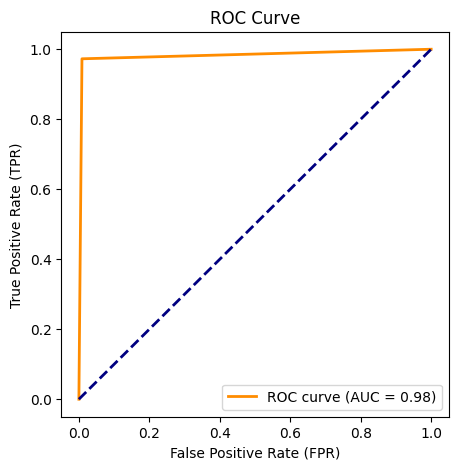

In [54]:
if not submission:
    roc_curve_plot(tf_idf_predictions)

**Final Model ROC curve**

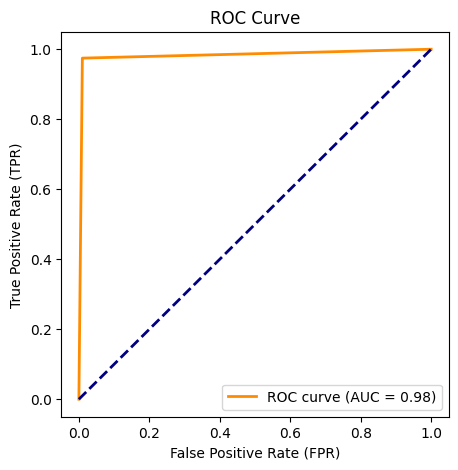

In [55]:
if not submission:
    roc_curve_plot(final_model_predictions)

**Precision-Recall Curve**

In [56]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(predictions):
    precision, recall, thresholds = precision_recall_curve(test_label, predictions)
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC-PR = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall (Sensitivity, True Positive Rate)')
    plt.ylabel('Precision (Positive Predictive Value)')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

**CNN-BiLSTM PR curve**

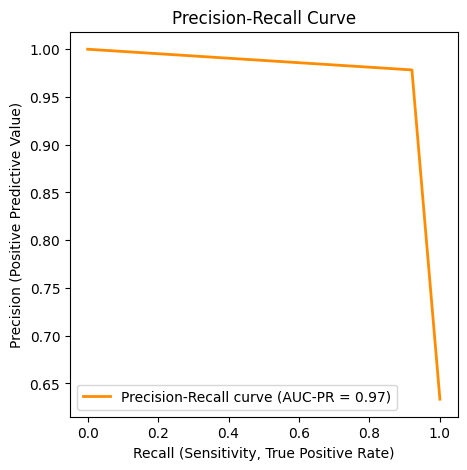

In [57]:
if not submission:
    precision_recall_curve_plot(cnn_BiLSTM_predictions)

**TF-IDF PR curve**

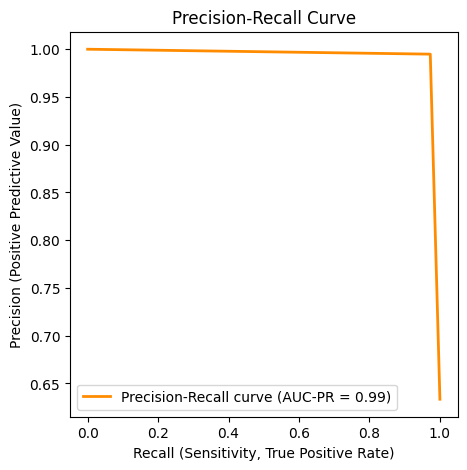

In [58]:
if not submission:
    precision_recall_curve_plot(tf_idf_predictions)

**Final Model PR curve**

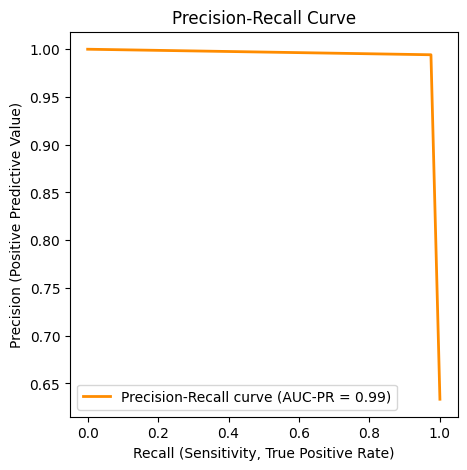

In [59]:
if not submission:
    precision_recall_curve_plot(final_model_predictions)

# Competition test data prediction

In [60]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
cnn_BiLSTM_test_data = text_vectorization(test['text'])
tf_idf_test_data = tf_idf_text_vectorization(test['text'])

final_preds = pd.Series(final_model.predict({'attentioned_cnn_BiLSTM_inputs': cnn_BiLSTM_test_data, 
                                             'tf_idf_classifier_inputs': tf_idf_test_data}).flatten(), name='Prediction')

final_output = pd.concat((test['id'], final_preds), axis=1)
final_output.to_csv('submission.csv', index=False)
print(f"Final prediction: \n {final_output}")

1/1 [==============================] - 0s 304ms/step
Final prediction: 
          id  Prediction
0  0000aaaa    0.985164
1  1111bbbb    0.985164
2  2222cccc    0.985164
